# Import Libraries

In [1]:
import requests
import os
import sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from pickle import dump
from sklearn.metrics import accuracy_score
import numpy as np 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings


# Import Data

In [2]:
# URL del archivo CSV
url = "https://raw.githubusercontent.com/4GeeksAcademy/naive-bayes-project-tutorial/main/playstore_reviews.csv"

# Nombre del archivo de destino
nombre_archivo = "comments.csv"

# Ruta completa al directorio de trabajo
directorio_trabajo = "/workspaces/alfonsoMG_naive_bayes/data/raw/"

# Ruta completa al archivo CSV de destino
ruta_archivo = os.path.join(directorio_trabajo, nombre_archivo)

# Descargar el archivo CSV desde la URL
response = requests.get(url)

with open(ruta_archivo, 'wb') as f:
    f.write(response.content)



# DataSet Cleaning

In [3]:
csv_path = "/workspaces/alfonsoMG_naive_bayes/data/raw/comments.csv"

df = pd.read_csv(csv_path)

df.head()

,package_name,review,polarity
0,com.facebook.katana,privacy at least put some option appear offli...,0
1,com.facebook.katana,"messenger issues ever since the last update, ...",0
2,com.facebook.katana,profile any time my wife or anybody has more ...,0
3,com.facebook.katana,the new features suck for those of us who don...,0
4,com.facebook.katana,forced reload on uploading pic on replying co...,0


In [4]:
df.drop("package_name", axis = 1 , inplace = True)
df.head()

,review,polarity
0,privacy at least put some option appear offli...,0
1,"messenger issues ever since the last update, ...",0
2,profile any time my wife or anybody has more ...,0
3,the new features suck for those of us who don...,0
4,forced reload on uploading pic on replying co...,0


In [5]:
df["review"] = df["review"].str.lower().replace('[^\w\s\']', ' ', regex=True).str.split().apply(lambda x: ' '.join(filter(lambda word: word.isalpha() and len(word) > 3, x)))
df["review"].head(40) 

0     privacy least some option appear offline mean ...
1     messenger issues ever since last update initia...
2     profile time wife anybody more than post view ...
3     features suck those have working back button g...
4     forced reload uploading replying comment last ...
5     edit posts things such profile picture when ed...
6     major flaws constant updates always getting in...
7     video issues since forced into this update vid...
8     this update completely destroyed facebook load...
9     posting issues last week been ghost post feeds...
10    what heck status updates chronological order h...
11    suck time when want something error will come ...
12    connection issues everytime click link profile...
13    external links working after updated latest ve...
14    this please tried editing profile pictures pas...
15    buggy when edit post through mobile that post ...
16    connection issues always says refresh later wh...
17    back facebook email thats wrong password m

# Train/Test Split

In [6]:
X = df["review"]
y = df["polarity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 24)
X_train.head()

68     after observation above things should hated th...
768                                    errors bugs error
722    still cool guys please this still cool after t...
94     facebook ripoff used connections connections n...
640    many useless features does anybody actually sp...
Name: review, dtype: object

In [7]:
X_train.to_csv("/workspaces/alfonsoMG_naive_bayes/data/processed/X_train.csv")
X_test.to_csv("/workspaces/alfonsoMG_naive_bayes/data/processed/X_test.csv")
y_train.to_csv("/workspaces/alfonsoMG_naive_bayes/data/processed/y_train.csv")
y_test.to_csv("/workspaces/alfonsoMG_naive_bayes/data/processed/y_test.csv")

In [8]:
nltk.download('stopwords')
stop_words = list(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
vec_model = CountVectorizer(stop_words = stop_words)
X_train = vec_model.fit_transform(X_train).toarray()
X_test = vec_model.transform(X_test).toarray()

In [10]:
models = [
    (GaussianNB(), "Gaussian"),
    (MultinomialNB(), "Multinomial"),
    (BernoulliNB(), "Bernoulli")
]

min_difference = float('inf')
best_model_name = ''

for model, name in models:
    model.fit(X_train, y_train)
    
    model_file = f"/workspaces/alfonsoMG_naive_bayes/models/model_{name.lower()}.pk"
    dump(model, open(model_file, "wb"))

    y_pred_train = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    print(f"{name} Train Accuracy: {train_accuracy}")

    y_pred_test = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    print(f"{name} Test Accuracy: {test_accuracy}")

    accuracy_difference = abs(train_accuracy - test_accuracy)
    print(f"{name} Accuracy Difference: {accuracy_difference}\n")

    if accuracy_difference < min_difference:
        min_difference = accuracy_difference
        best_model_name = name

print(f"The best model is: {best_model_name} with the smallest difference ({min_difference:.4f}) between train and test accuracy.")

Gaussian Train Accuracy: 0.9817415730337079
Gaussian Test Accuracy: 0.7486033519553073
Gaussian Accuracy Difference: 0.23313822107840065

Multinomial Train Accuracy: 0.9592696629213483
Multinomial Test Accuracy: 0.8212290502793296
Multinomial Accuracy Difference: 0.13804061264201872

Bernoulli Train Accuracy: 0.9143258426966292
Bernoulli Test Accuracy: 0.7430167597765364
Bernoulli Accuracy Difference: 0.17130908292009284

The best model is: Multinomial with the smallest difference (0.1380) between train and test accuracy.


In [11]:
hyperparams = {
    "alpha": [0] + list(np.arange(1.0, 10, 0.1)),  # Asegurarse de que se incluya 0 y utilizar un paso más pequeño
    "fit_prior": [True, False],
}

In [12]:
multinomial = MultinomialNB()
grid = GridSearchCV(multinomial, hyperparams, scoring = 'accuracy', cv = 5)
grid.fit(X_train, y_train)


/home/vscode/.local/lib/python3.11/site-packages/sklearn/naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/naive

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0, 1.0, 1.1, 1.2000000000000002,
                                   1.3000000000000003, 1.4000000000000004,
                                   1.5000000000000004, 1.6000000000000005,
                                   1.7000000000000006, 1.8000000000000007,
                                   1.9000000000000008, 2.000000000000001,
                                   2.100000000000001, 2.200000000000001,
                                   2.300000000000001, 2.4000000000000012,
                                   2.5000000000000013, 2.6000000000000014,
                                   2.7000000000000015, 2.8000000000000016,
                                   2.9000000000000017, 3.0000000000000018,
                                   3.100000000000002, 3.200000000000002,
                                   3.300000000000002, 3.400000000000002,
                                   3.500000000000002, 3.6000000000000023,
                                   3.7000000000000024, 3.8000000000000025, ...],
                         'fit_prior': [True, False]},
             scoring='accuracy')

In [13]:
best_hyper = grid.best_params_ 
best_model = MultinomialNB(**best_hyper)
best_model.fit(X_train, y_train)

MultinomialNB(alpha=3.400000000000002, fit_prior=False)

In [14]:
y_pred = best_model.predict(X_train)
train_score = accuracy_score(y_train, y_pred)

y_pred = best_model.predict(X_test)
test_score = accuracy_score(y_test, y_pred)

print(f"The accuracy score for Train is : {train_score}")
print(f"The accuracy score for Test is : {test_score}")
print(f"Train/Test difference: {train_score - test_score}")

The accuracy score for Train is : 0.9283707865168539
The accuracy score for Test is : 0.8324022346368715
Train/Test difference: 0.09596855187998243


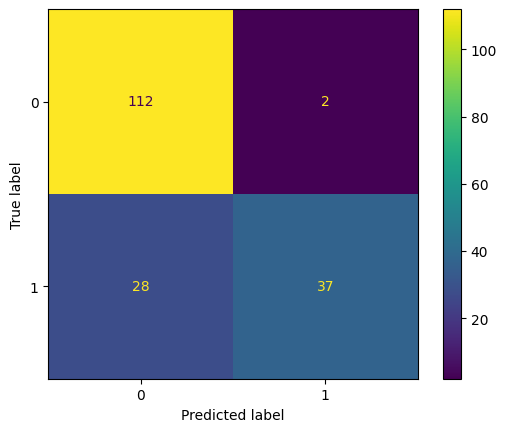

In [15]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

In [16]:
hyperparams = {
    "alpha": [0] + list(np.arange(1.0, 100, 0.1)),  # Asegurarse de que se incluya 0 y utilizar un paso más pequeño
    "fit_prior": [True, False],
    "class_prior": [None, np.linspace(0.1, 1, 10)]
}

In [17]:
# Desactivar FutureWarnings específicos
warnings.simplefilter(action='ignore', category=FutureWarning)

# Desactivar UserWarnings específicos
warnings.simplefilter(action='ignore', category=UserWarning)


warnings.filterwarnings("ignore", category=sklearn.exceptions.FitFailedWarning)

In [19]:
# Realizar la búsqueda aleatoria con diferentes random_state
num_iterations = 40
results = []

for i in range(num_iterations):
    random_state = np.random.randint(1, 100)
    random_search = RandomizedSearchCV(multinomial, hyperparams, n_iter=100, cv=5, scoring="accuracy", random_state=random_state)
    random_search.fit(X_train, y_train)
    
    best_hyper = random_search.best_params_
    print(f"Iteration {i + 1} - Mejores hiperparámetros: {best_hyper}")

    results.append((best_hyper, random_search.best_score_))

# Seleccionar el mejor conjunto de hiperparámetros basado en el rendimiento promedio de validación cruzada
best_hyper, _ = max(results, key=lambda x: x[1])
print(f"Mejores hiperparámetros: {best_hyper}")

# Entrenar el modelo final con los mejores hiperparámetros
final_model = MultinomialNB(**best_hyper)
final_model.fit(X_train, y_train)

# Evaluar en conjunto de prueba
y_pred_train = final_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Accuracy score for Train: {train_accuracy}")

y_pred_test = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy score for Test: {test_accuracy}")

# Calcular y mostrar la diferencia entre el conjunto de entrenamiento y prueba
difference = train_accuracy - test_accuracy
print(f"Train/Test difference: {difference}")


Iteration 1 - Mejores hiperparámetros: {'fit_prior': False, 'class_prior': None, 'alpha': 4.800000000000003}
Iteration 2 - Mejores hiperparámetros: {'fit_prior': True, 'class_prior': None, 'alpha': 2.100000000000001}
Iteration 3 - Mejores hiperparámetros: {'fit_prior': False, 'class_prior': None, 'alpha': 4.600000000000003}
Iteration 4 - Mejores hiperparámetros: {'fit_prior': False, 'class_prior': None, 'alpha': 9.200000000000006}
Iteration 5 - Mejores hiperparámetros: {'fit_prior': False, 'class_prior': None, 'alpha': 6.100000000000005}
Iteration 6 - Mejores hiperparámetros: {'fit_prior': False, 'class_prior': None, 'alpha': 5.300000000000004}
Iteration 7 - Mejores hiperparámetros: {'fit_prior': False, 'class_prior': None, 'alpha': 5.700000000000005}
Iteration 8 - Mejores hiperparámetros: {'fit_prior': True, 'class_prior': None, 'alpha': 2.4000000000000012}
Iteration 9 - Mejores hiperparámetros: {'fit_prior': False, 'class_prior': None, 'alpha': 5.700000000000005}
Iteration 10 - Mejor